In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from sys import path
from os.path import abspath
from os import environ
path.append(abspath("/home/ng136/nico"))
environ['R_HOME'] = '/home/ng136/nico/neutrophils/analysis/conda-env/lib/R' #path to your R installation
rlib_loc="/n/groups/klein/nico/neutrophils/analysis/conda-env/lib/R/library" #path to R libraries
import ng_functions as ng

from glob import glob
from pathlib import Path
import warnings
from time import time
from datetime import datetime
from tqdm import tqdm

# Load + prepare Zilionis reference data

In [3]:
zdata = sc.read('/n/groups/klein/nico/neutrophils/backups/zilionis_mouse_reannotated_15939x27045_backup_220323_16h11.h5ad')
zdata.layers['umi'] = zdata.X.copy()
zdata.X = zdata.layers['cp10k'].copy()

# Load exp 3

In [4]:
adata = sc.read('/n/groups/klein/nico/neutrophils/backups/totalseq_exp3_all_cells_acd40_embedding_33603x17824_backup_220314_15h39.h5ad')
adata.layers['umi'] = adata.X.copy()
adata.X = adata.layers['cp10k'].copy()

# Classify exp 3 via Multinomial likelihood Naive Bayes

In [5]:
most_likely = ng.parallel_cell_classifier(adata = adata, bdata = zdata, state_column_b = 'state_label', comment='exp3_gungabeesoon_by_zilionis_reannotated', 
                                                                save_dir = '/n/groups/klein/nico/neutrophils/backups/', progress_bar = True, 
                                                                step = np.ceil(len(adata)/4).astype(int), return_most_likely=True, nproc=4)

No. of genes in data set to be classified: 17824.
No. of genes in data set to use as template for classification: 27045.
No. of genes present/detected in both data sets: 13803.


 75%|███████▌  | 25203/33603 [02:11<00:30, 278.86cells/s]
4it [02:11, 32.79s/it]
100%|██████████| 33603/33603 [02:11<00:00, 254.63cells/s]


Class log-likelihoods stored at /n/groups/klein/nico/neutrophils/backups/loglikelihoods_multinomial_naive_bayes_exp3_gungabeesoon_by_zilionis_reannotated_220323_16h25.npz


In [5]:
most_likely = pd.DataFrame(**np.load('/n/groups/klein/nico/neutrophils/backups/loglikelihoods_multinomial_naive_bayes_exp3_gungabeesoon_by_zilionis_reannotated_220323_16h25.npz', allow_pickle=True)).idxmax()
most_likely.index = adata.obs_names

In [6]:
adata.obs['most_likely_Zilionis'] = most_likely
adata.obs['most_likely_Zilionis'] = adata.obs['most_likely_Zilionis'].astype('category')

# Smooth N4/N6 labels

In [7]:
knn_labels = ng.knn_label_smoothing(adata, 'most_likely_Zilionis', weighted=False, return_df=True)

adata.obs['smoothed_Zilionis'] =  adata.obs['most_likely_Zilionis']
adata.obs['smoothed_Zilionis'][(adata.obs['most_likely_Zilionis'] == 'N6') & (knn_labels['N4'] >= 1)] = 'N4'

[<Figure size 1449x600 with 2 Axes>]

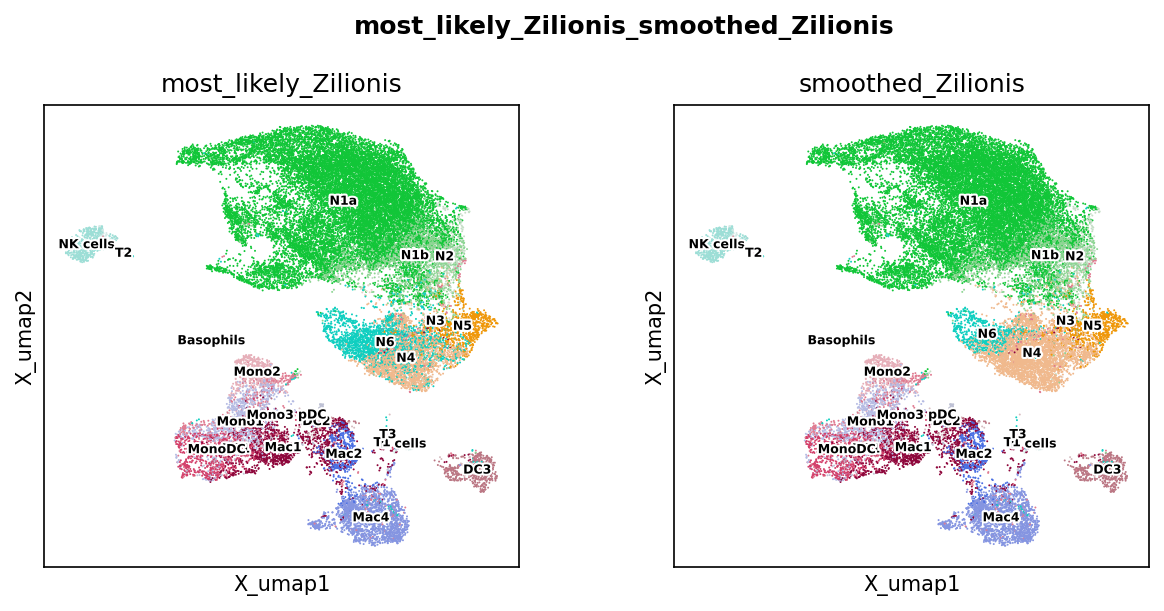

In [8]:
ng.umap_plot(adata, ['most_likely_Zilionis','smoothed_Zilionis'])

[<Figure size 1449x600 with 2 Axes>]

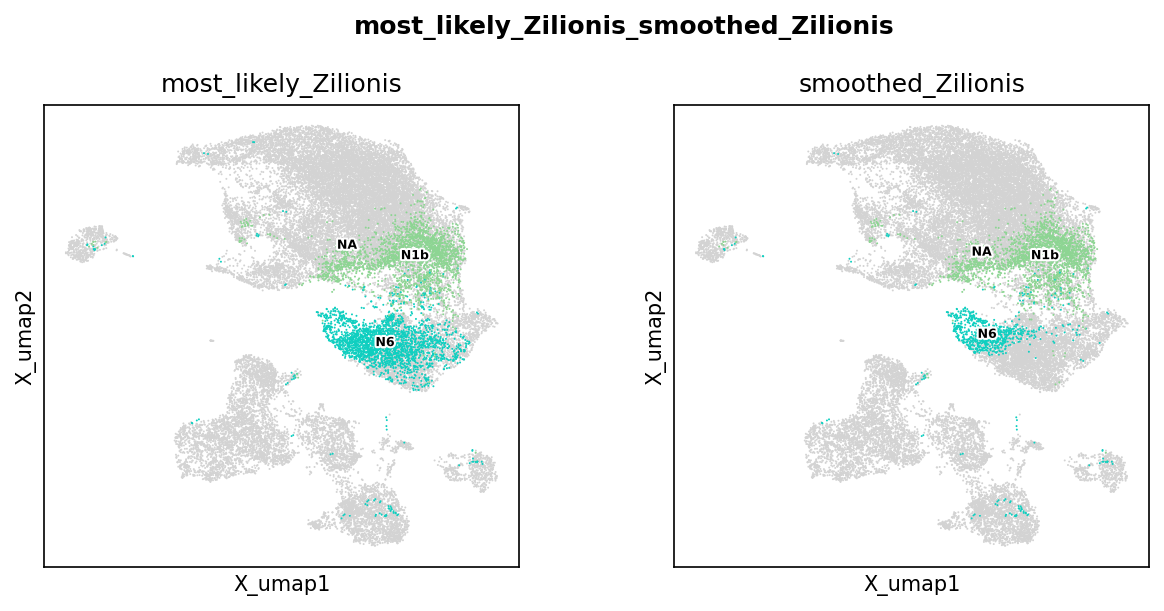

In [10]:
ng.umap_plot(adata, ['most_likely_Zilionis','smoothed_Zilionis'], groups=['N1b', 'N6'])

# Save

In [9]:
adata.X = adata.layers['umi'].copy()

In [10]:
start = time()
fname = '/n/groups/klein/nico/neutrophils/backups/totalseq_exp3_all_cells_acd40_annotated_embedding_{}x{}_backup_{}.h5ad'.format(*adata.shape,ng.now())
adata.write(fname)
print(fname)
ng.print_etime(start)

/n/groups/klein/nico/neutrophils/backups/totalseq_exp3_all_cells_acd40_annotated_embedding_33603x17824_backup_220325_12h01.h5ad
Elapsed time: 1 minutes and 35.4 seconds.
